# Unit 5 - Financial Planning

In [1]:
# Initial imports
import os
import requests
import json
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
import warnings
warnings.filterwarnings("ignore")
from MCForecastTools import MCSimulation

%matplotlib inline

In [2]:
# Load .env enviroment variables
load_dotenv('keys.env')

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [3]:
# Set current amount of crypto assets
my_btc_shares = 1.2
my_eth_shares = 5.3

In [4]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=USD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=USD"

In [5]:
# Fetch current BTC price
response_data = requests.get(btc_url).json()
btc_price = response_data['data']['1']['quotes']['USD']['price']

# Fetch current ETH price
response_data = requests.get(eth_url).json()
eth_price = response_data['data']['1027']['quotes']['USD']['price']

# Compute current value of my crypto
my_btc_value = btc_price*my_btc_shares
my_eth_value = eth_price*my_eth_shares

# Print current crypto wallet balance
print(f"The current value of your {my_btc_shares} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth_shares} ETH is ${my_eth_value:0.2f}")

The current value of your 1.2 BTC is $33324.00
The current value of your 5.3 ETH is $9314.86


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [6]:
# Set current amount of shares
my_agg_shares = 200
my_spy_shares = 50

In [7]:
# Set Alpaca API key and secret
alpaca_public_key = os.getenv('ALPACA_API_KEY')
alpaca_secret_key = os.getenv('ALPACA_SECRET_KEY')

# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_public_key,
    alpaca_secret_key,
    api_version="v2")

In [8]:
# Format current date as ISO format
today = pd.Timestamp('2023-03-20', tz = 'America/New_York').isoformat()

# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to "1Day" for Alpaca API
timeframe = "1Day"

# Reorganize the DataFrame, Separate ticker data
df_portfolio = alpaca.get_bars(
    tickers, 
    timeframe, 
    start = today, 
    end = today, 
).df

SPY = df_portfolio[df_portfolio['symbol'] == 'SPY'].drop('symbol', axis = 1)
AGG = df_portfolio[df_portfolio['symbol'] == 'AGG'].drop('symbol', axis = 1)
df_portfolio.sort_index(ascending = False, axis = 0, inplace = True)

# Get current closing prices for SPY and AGG
SPY_closing_price = df_portfolio['close'][0]
AGG_closing_price = df_portfolio['close'][1]

# Concatenate the ticker DataFrames
df_portfolio = pd.concat([SPY, AGG], axis = 1, keys = ['SPY', 'AGG'])
df_portfolio.sort_index(ascending = False, axis = 0, inplace = True)

# Preview DataFrame
df_portfolio.head()

# Compute the current value of shares
SPY_value = SPY_closing_price * my_spy_shares
AGG_value = AGG_closing_price * my_agg_shares

In [9]:
# Print current value of shares
print(f"The current value of your {my_spy_shares} SPY shares is ${SPY_value:0.2f}")
print(f"The current value of your {my_agg_shares} AGG shares is ${AGG_value:0.2f}")

The current value of your 50 SPY shares is $4955.00
The current value of your 200 AGG shares is $78748.00


### Savings Health Analysis

In [10]:
# Set monthly household income
monthly_income = 12000

# Consolidate financial assets data
total_value_crypto = my_btc_value + my_eth_value
total_value_stocks = SPY_value + AGG_value

# Create savings DataFrame
df_savings = pd.DataFrame({'amount': [total_value_crypto, total_value_stocks]}, index = ['crypto', 'stocks'])

# Display savings DataFrame
display(df_savings)

,amount
crypto,42638.856
stocks,83703.000


<AxesSubplot: title={'center': 'Personal Savings'}, ylabel='amount'>

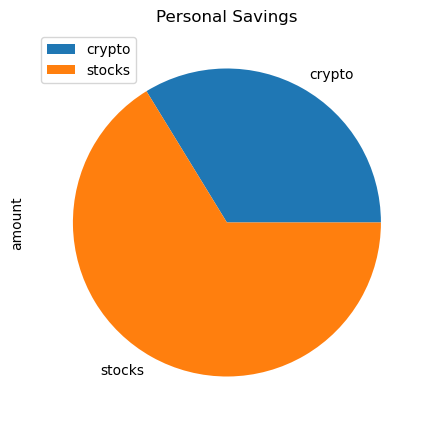

In [11]:
# Plot savings pie chart
df_savings.plot.pie(title = 'Personal Savings', y = 'amount', figsize = (5,5))

In [12]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3
print(emergency_fund)

# Calculate total amount of savings
total_savings = total_value_stocks + total_value_crypto
print(total_savings)

# Validate saving health
if total_savings > emergency_fund: 
    print(f'Congrats! You have enough money in this fund --> ${total_savings:,.2f}')
elif total_savings == emergency_fund: 
    print('Congrats on reaching this Financial Goal!')
elif total_savings < emergency_fund: 
    account_deficit = emergency_fund - total_savings
    print(f'You are ${account_deficit:,.2f} away from your Financial Goal!')

36000
126341.856
Congrats! You have enough money in this fund --> $126,341.86


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [13]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp('2016-05-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2021-05-01', tz='America/New_York').isoformat()

In [14]:
# Get 4 years' worth of historical data for SPY and AGG
df_stock_data = alpaca.get_bars(
    tickers, 
    timeframe, 
    start = start_date, 
    end = end_date, 
).df

# Reorganize the DataFrame
# Separate ticker data
SPY = df_stock_data[df_stock_data['symbol'] == 'SPY'].drop('symbol', axis = 1)
AGG = df_stock_data[df_stock_data['symbol'] == 'AGG'].drop('symbol', axis = 1)

# Concatenate the ticker DataFrames
df_stock_data = pd.concat([SPY, AGG], axis = 1, keys = ['SPY', 'AGG'])

# Display sample data
df_stock_data.head()

SPY                                       \
                             open    high     low     close     volume   
timestamp                                                                
2016-05-02 04:00:00+00:00  206.92  208.18  206.41  207.9700   61908515   
2016-05-03 04:00:00+00:00  206.52  206.80  205.28  206.1592  106422142   
2016-05-04 04:00:00+00:00  204.99  205.85  204.42  205.0100   92199810   
2016-05-05 04:00:00+00:00  205.56  205.98  204.47  204.9700   67597222   
2016-05-06 04:00:00+00:00  204.08  205.77  203.88  205.7200   89131004   

                                                      AGG                      \
                          trade_count        vwap    open      high       low   
timestamp                                                                       
2016-05-02 04:00:00+00:00      263580  207.294812  110.74  110.7400  110.5200   
2016-05-03 04:00:00+00:00      377518  206.312060  110.89  110.9450  110.7500   
2016-05-04 04:00:00+00:00      345261  205.090172  110.91  110.9315  110.7595   
2016-05-05 04:00:00+00:00      280622  205.141555  110.92  111.1600  110.8010   
2016-05-06 04:00:00+00:00      340335  204.937074  111.12  111.1200  110.9700   

                                                                     
                             close   volume trade_count        vwap  
timestamp                                                            
2016-05-02 04:00:00+00:00  110.605  3553939       15119  110.627199  
2016-05-03 04:00:00+00:00  110.810  3044940       15662  110.865995  
2016-05-04 04:00:00+00:00  110.860  2920608       13982  110.879063  
2016-05-05 04:00:00+00:00  111.140  3008142       15707  111.028363  
2016-05-06 04:00:00+00:00  110.970  2718710       12697  111.031967

In [15]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
sim_returns = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.40,.60],
    num_simulation=500,
    num_trading_days=252*30
)
sim_returns.portfolio_data.head()

SPY                                       \
                             open    high     low     close     volume   
timestamp                                                                
2016-05-02 04:00:00+00:00  206.92  208.18  206.41  207.9700   61908515   
2016-05-03 04:00:00+00:00  206.52  206.80  205.28  206.1592  106422142   
2016-05-04 04:00:00+00:00  204.99  205.85  204.42  205.0100   92199810   
2016-05-05 04:00:00+00:00  205.56  205.98  204.47  204.9700   67597222   
2016-05-06 04:00:00+00:00  204.08  205.77  203.88  205.7200   89131004   

                                                                   AGG  \
                          trade_count        vwap daily_return    open   
timestamp                                                                
2016-05-02 04:00:00+00:00      263580  207.294812          NaN  110.74   
2016-05-03 04:00:00+00:00      377518  206.312060    -0.008707  110.89   
2016-05-04 04:00:00+00:00      345261  205.090172    -0.005574  110.91   
2016-05-05 04:00:00+00:00      280622  205.141555    -0.000195  110.92   
2016-05-06 04:00:00+00:00      340335  204.937074     0.003659  111.12   

                                                                             \
                               high       low    close   volume trade_count   
timestamp                                                                     
2016-05-02 04:00:00+00:00  110.7400  110.5200  110.605  3553939       15119   
2016-05-03 04:00:00+00:00  110.9450  110.7500  110.810  3044940       15662   
2016-05-04 04:00:00+00:00  110.9315  110.7595  110.860  2920608       13982   
2016-05-05 04:00:00+00:00  111.1600  110.8010  111.140  3008142       15707   
2016-05-06 04:00:00+00:00  111.1200  110.9700  110.970  2718710       12697   

                                                    
                                 vwap daily_return  
timestamp                                           
2016-05-02 04:00:00+00:00  110.627199          NaN  
2016-05-03 04:00:00+00:00  110.865995     0.001853  
2016-05-04 04:00:00+00:00  110.879063     0.000451  
2016-05-05 04:00:00+00:00  111.028363     0.002526  
2016-05-06 04:00:00+00:00  111.031967    -0.001530

In [16]:
# Forecast 30 years of cumulative returns
sim_returns.calc_cumulative_return() 

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.998339,0.996958,1.000557,0.998383,0.991932,1.000110,1.006843,0.999518,1.006052,0.999193,...,0.996536,1.006798,0.999802,0.996268,1.009590,1.000757,0.990847,0.999088,0.993236,1.000682
2,0.995978,0.997954,0.998620,1.001953,0.991179,0.999132,1.011403,0.994672,1.008003,0.995400,...,0.993756,1.002761,1.004154,0.990011,1.009123,0.995871,0.999112,1.001393,0.990994,1.004604
3,0.995642,0.993899,0.998656,0.997852,0.984658,0.993963,1.008206,0.990056,1.006821,1.006047,...,0.988398,0.999966,1.006122,0.985285,1.015141,0.996608,1.004267,0.994056,0.990174,1.005937
4,0.996041,0.987223,0.996824,0.989735,0.991428,0.993675,1.005039,0.992800,1.005338,1.014213,...,0.992523,1.004170,1.013513,0.986661,1.015156,1.002176,1.005218,0.998065,0.981790,1.006758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,3.870624,5.023579,9.491780,10.817991,3.127764,1.872645,6.575708,13.396357,11.402056,6.340477,...,4.034973,5.755606,7.199279,4.989862,10.423370,7.432094,6.838211,5.980742,24.182218,3.276342
7557,3.859350,5.041819,9.538310,10.875194,3.106744,1.887010,6.562747,13.352396,11.389518,6.377733,...,4.024220,5.788002,7.179858,4.993181,10.438682,7.415876,6.819955,5.975576,24.087158,3.305869
7558,3.875565,5.044042,9.617201,10.876600,3.108305,1.881391,6.536149,13.307803,11.387030,6.406161,...,4.044372,5.786209,7.223568,4.993459,10.425571,7.437441,6.840998,5.948578,24.121306,3.290744
7559,3.874101,5.058531,9.581025,10.946472,3.099019,1.880613,6.546957,13.235241,11.328943,6.449202,...,4.040045,5.863344,7.259698,4.988778,10.381199,7.463328,6.838432,5.897441,24.003795,3.296566


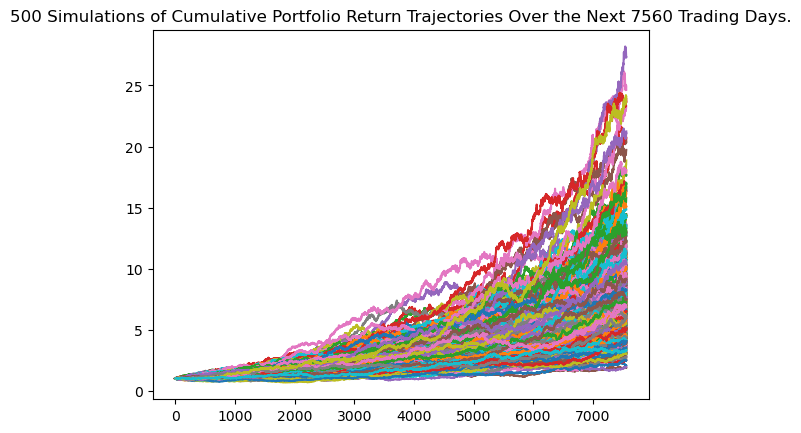

In [17]:
# Plot simulation outcomes
plots = sim_returns.plot_simulation()

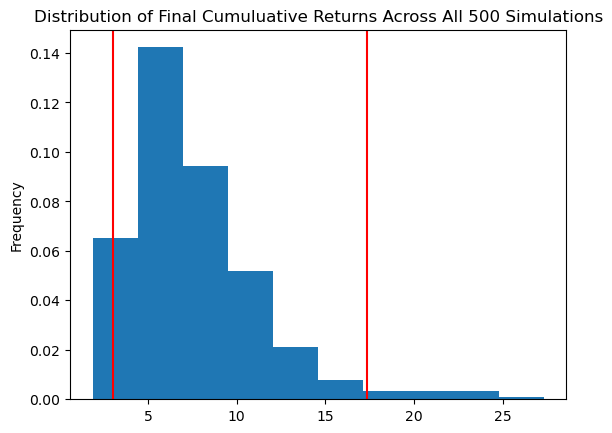

In [18]:
# Plot probability distribution and confidence intervals
dist_plot = sim_returns.plot_distribution()

### Retirement Analysis

In [19]:
# Fetch summary statistics from the Monte Carlo simulation results
all_stats = sim_returns.summarize_cumulative_return()

# Print summary statistics
print(all_stats)

count           500.000000
mean              7.596149
std               3.754045
min               1.879092
25%               5.044303
50%               6.841199
75%               9.212194
max              27.320576
95% CI Lower      3.016807
95% CI Upper     17.357991
Name: 7560, dtype: float64


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [20]:
# Set initial investment
initial_investment = 20_000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
even_ci_lower = round(all_stats[8] * initial_investment, 2)
even_ci_upper = round(all_stats[9] * initial_investment, 2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment:,.2f} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${even_ci_lower:,.2f} and ${even_ci_upper:,.2f}")

There is a 95% chance that an initial investment of $20,000.00 in the portfolio over the next 30 years will end within in the range of $60,336.15 and $347,159.82


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [21]:
# Set initial investment
initial_investment = 20_000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
even_ci_lower = round(all_stats[8] * initial_investment, 2)
even_ci_upper = round(all_stats[9] * initial_investment, 2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment:,.2f} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${even_ci_lower:,.2f} and ${even_ci_upper:,.2f}")

There is a 95% chance that an initial investment of $30,000.00 in the portfolio over the next 30 years will end within in the range of $90,504.22 and $520,739.73


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [22]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
MC_stock_data = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.60, .40],
    num_simulation = 500,
    num_trading_days = 252 * 5
)

In [23]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_stock_data.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.009522,0.997927,1.005334,0.994426,0.992705,0.992680,1.005251,1.011285,1.012603,1.005534,...,1.003979,1.004865,1.004253,0.988899,0.991640,0.996397,0.997267,0.993620,0.995757,1.013301
2,1.005790,0.993356,1.002895,0.989497,0.999894,0.979915,1.005514,1.003847,1.010794,1.015628,...,1.004804,1.014954,1.002879,0.982393,0.987208,1.000861,0.999130,1.000108,0.994528,1.019107
3,1.009691,0.992690,1.007349,0.977025,1.005781,0.982982,1.014999,1.006858,1.014949,1.028285,...,0.996374,1.015435,0.988476,0.984493,0.982575,1.003760,1.002394,1.009457,0.989017,1.022416
4,1.010923,0.992620,1.003549,0.973678,1.010781,0.981742,1.012054,1.010307,1.002000,1.023870,...,0.990311,1.017472,0.980988,0.984149,0.998664,1.021330,0.997472,1.010696,0.989338,1.015353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.283140,1.197623,1.161549,2.626303,1.837385,1.081453,1.310109,1.531963,1.793104,1.584159,...,1.601872,1.705357,2.036085,1.834699,1.146519,1.784531,1.172397,2.063945,1.638376,1.276809
1257,1.294534,1.203365,1.173327,2.623641,1.841111,1.088009,1.321562,1.522129,1.770869,1.588354,...,1.618642,1.688579,2.038687,1.849094,1.144680,1.786871,1.177501,2.070352,1.636681,1.288186
1258,1.302698,1.198038,1.171412,2.635657,1.836328,1.084333,1.328939,1.524850,1.777967,1.591320,...,1.611513,1.696397,2.035801,1.870683,1.147321,1.784605,1.175828,2.037906,1.648775,1.290987
1259,1.294697,1.187257,1.186380,2.663678,1.843319,1.084870,1.335787,1.523614,1.768070,1.593191,...,1.592820,1.677403,2.038096,1.890136,1.153800,1.778603,1.187048,2.021482,1.649174,1.301927


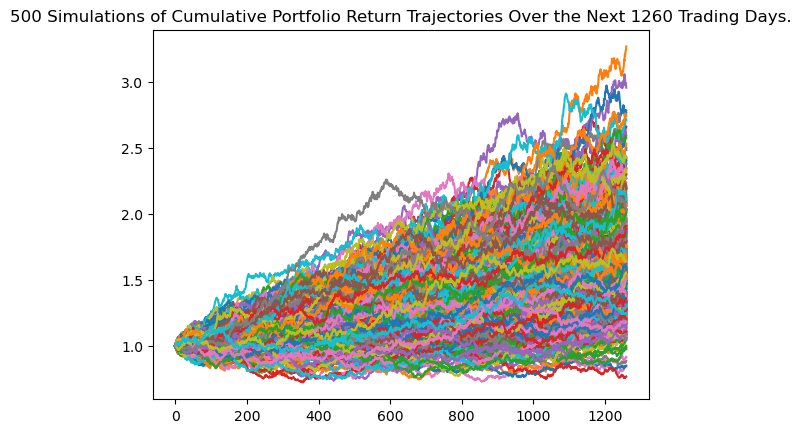

In [24]:
# Plot simulation outcomes
line_plot = MC_stock_data.plot_simulation().plot(figsize = (10,5))

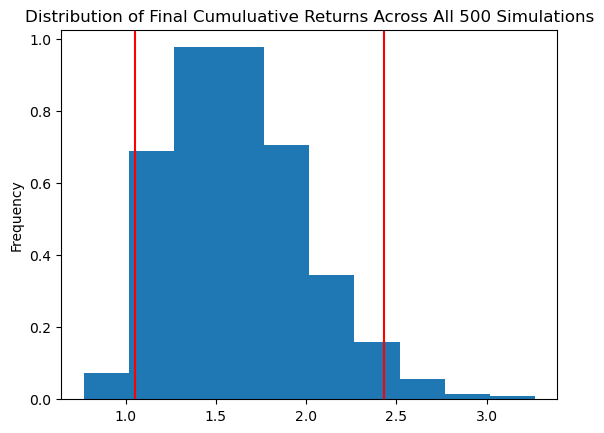

In [25]:
# Plot probability distribution and confidence intervals
dist_plot = MC_stock_data.plot_distribution()

In [26]:
# Fetch summary statistics from the Monte Carlo simulation results
even_tbl = MC_stock_data.summarize_cumulative_return()

# Print summary statistics
print(even_tbl)

count           500.000000
mean              1.616795
std               0.381215
min               0.768420
25%               1.322094
50%               1.580906
75%               1.862810
max               3.267563
95% CI Lower      1.051345
95% CI Upper      2.428728
Name: 1260, dtype: float64


In [27]:
# Set initial investment
initial_investment = 40_000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
even_ci_lower = round(even_tbl[8] * initial_investment, 2)
even_ci_upper = round(even_tbl[9] * initial_investment, 2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment:,.2f} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${even_ci_lower:,.2f} and ${even_ci_upper:,.2f}")

There is a 95% chance that an initial investment of $40,000.00 in the portfolio over the next 5 years will end within in the range of $42,053.78 and $97,149.13


### Ten Years Retirement Option

In [28]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
MC_stock_data = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.60, .40],
    num_simulation = 500,
    num_trading_days = 252 * 10
)

In [29]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
MC_stock_data.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.997467,1.000370,0.989464,1.007043,0.999433,0.999104,0.993731,0.992043,0.998874,0.996059,...,1.005397,0.997840,1.004765,0.999712,1.008278,1.013858,1.002710,0.991673,1.013776,0.999276
2,1.000583,0.989275,0.988914,1.010150,1.010118,1.008836,1.002256,0.998195,1.013099,0.998041,...,1.000957,1.005707,1.013327,0.992122,0.997961,1.026563,0.998085,0.983828,1.008485,0.982423
3,0.997297,0.990039,0.983435,1.013938,1.002653,1.006607,0.999286,0.995201,1.020550,1.005039,...,1.013563,1.008001,1.015547,0.996527,1.009428,1.039219,1.012702,0.980404,1.010887,0.981234
4,0.998935,0.983079,0.982224,1.007365,1.004002,1.008635,0.997822,1.004755,1.018016,1.003779,...,1.012525,1.006085,1.013637,0.999383,1.004955,1.037675,1.011792,0.986752,1.007018,0.979407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,2.739118,1.701978,3.176949,2.792827,4.114992,3.122151,2.673647,4.789012,1.310501,1.377034,...,1.952803,2.162949,1.923849,2.994168,4.261943,3.256611,1.872214,3.511631,3.394237,2.093404
2517,2.695229,1.702836,3.153667,2.763530,4.117929,3.120698,2.669548,4.775351,1.310657,1.382733,...,1.956166,2.164202,1.917523,3.004487,4.241976,3.270373,1.857572,3.526652,3.388099,2.108034
2518,2.680738,1.699921,3.129290,2.750826,4.136471,3.128134,2.637886,4.776493,1.320294,1.386646,...,1.980231,2.183083,1.918871,2.997234,4.218547,3.291468,1.849960,3.529243,3.365265,2.090477
2519,2.689980,1.712409,3.136645,2.746072,4.119400,3.119306,2.627483,4.829461,1.315040,1.376185,...,1.950538,2.185783,1.913045,2.987870,4.252284,3.285175,1.854359,3.466361,3.355904,2.101728


[]

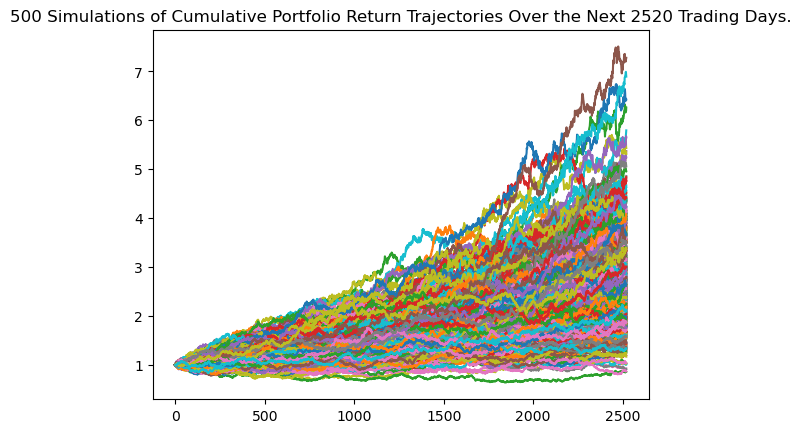

In [30]:
# Plot simulation outcomes
MC_stock_data.plot_simulation().plot(figsize = (10,5))

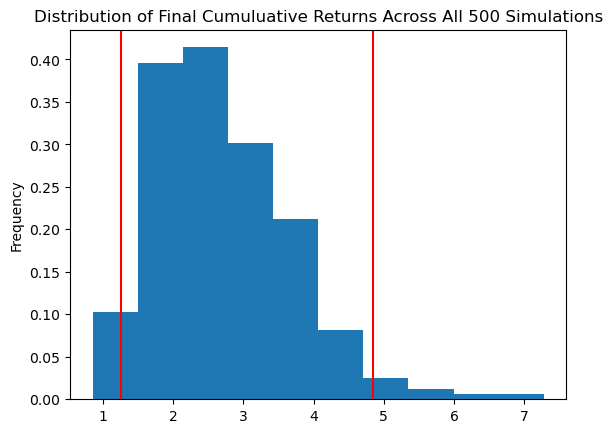

In [31]:
# Plot probability distribution and confidence intervals
dist_plot = MC_stock_data.plot_distribution()

In [32]:
# Fetch summary statistics from the Monte Carlo simulation results
even_tbl = MC_stock_data.summarize_cumulative_return()

# Print summary statistics
print(even_tbl)

count           500.000000
mean              2.714531
std               0.978487
min               0.857122
25%               1.994854
50%               2.563143
75%               3.320663
max               7.277995
95% CI Lower      1.261680
95% CI Upper      4.848497
Name: 2520, dtype: float64


In [33]:
# Set initial investment
initial_investment = 60_000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
even_ci_lower = round(even_tbl[8] * initial_investment, 2)
even_ci_upper = round(even_tbl[9] * initial_investment, 2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment:,.2f} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${even_ci_lower:,.2f} and ${even_ci_upper:,.2f}")

There is a 95% chance that an initial investment of $60,000.00 in the portfolio over the next 10 years will end within in the range of $75,700.81 and $290,909.81
